# The four steps of causal inference

## I. Model a causal problem
- Create a causal DAG for your system of interest.

## II. Identify a target estimand under the model
- Identify the causal estimand under the assumptions of the causal DAG.

## III. Estimate the causal effect based on the identified estimand
- Estimate the estimand using any kind of Stats/ML model e.g. linear regression, random forest etc.

## IV. Refute the obtain estimate
- Peform refutations on the estimate to test its robustness 


## Imports

In [1]:
import numpy as np
import pandas as pd

import dowhy
from dowhy import CausalModel
import econml
import warnings
BETA = 10


# Avoid printing dataconversion warnings from sklearn
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from econml.inference import BootstrapInference
from pandas.core.common import SettingWithCopyWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
from IPython.display import Image, display


In [2]:
# I/O Stuff
DATA_FILENAME = "csdh_clean.csv"
DATA_FILEPATH = "/Users/callum/Uni/GitHubRepos/surviving-the-icu/datasets/drain_data/" + DATA_FILENAME
csdh = pd.read_csv(DATA_FILEPATH)

---
## 0. Naïve Estimation (no causal inference)

In [58]:
df_withtreatment = csdh.loc[csdh['drain']==1]
df_notreatment = csdh.loc[csdh['drain']==0]
naive_est = np.mean(df_withtreatment['recurrence']) - np.mean(df_notreatment['recurrence'])
print(f"Without adjusting for any confounding, the naive causal estimate is computed as {naive_est}")

Without adjusting for any confounding, the naive causal estimate is computed as -0.09356128931064231


---
## I. Model a causal problem
* Create a causal model from the data and given graph.

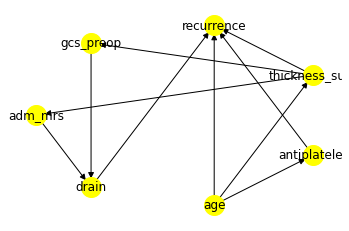

In [17]:
mp_dag = """digraph {
adm_mrs -> drain;
age -> antiplatelet;
age -> thickness_sum;
antiplatelet -> recurrence;
drain -> recurrence;
gcs_preop -> drain;
age -> recurrence;
thickness_sum -> adm_mrs;
thickness_sum -> gcs_preop;
thickness_sum -> recurrence}"""

mp_model = CausalModel(data=csdh, treatment='drain', outcome='recurrence', graph=causal_graph.replace("\n", " "))
mp_model.view_model()


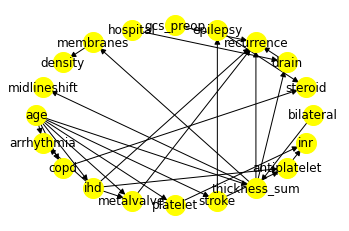

In [18]:
data_dag = """digraph {
age -> arrhythmia;
age -> copd;
age -> ihd ;
age -> metalvalve;
age -> platelet;
age -> stroke;
age -> thickness_sum;
antiplatelet -> inr;
bilateral -> thickness_sum;
copd -> steroid;
drain -> recurrence;
epilepsy -> steroid;
gcs_preop -> recurrence;
hospital -> drain;
ihd -> antiplatelet;
ihd -> arrhythmia;
ihd -> metalvalve;
ihd -> recurrence;
membranes -> density;
metalvalve -> recurrence;
platelet -> inr;
stroke -> antiplatelet;
stroke -> epilepsy;
thickness_sum -> drain;
thickness_sum -> membranes;
thickness_sum -> midlineshift;
thickness_sum -> recurrence;
}
"""
data_model = CausalModel(data=csdh, 
                        treatment='drain', outcome='recurrence', 
                        graph=big_graph.replace("\n", " "))
data_model.view_model()

---
## II. Identify a target estimand under the model

In [19]:
mp_estimand = mp_model.identify_effect(proceed_when_unidentifiable=True)
data_estimand = data_model.identify_effect(proceed_when_unidentifiable=True)

---
## III. Linear Regression Estimator

In [21]:
# III. Estimate the target estimand using a statistical method.
mp_lin_est = model.estimate_effect(mp_estimand,
                                   method_name="backdoor.linear_regression",
                                   control_value=0,
                                   treatment_value=1,
                                   target_units='ate'
                                  )
data_lin_est = new_model.estimate_effect(data_estimand,
                                         method_name="backdoor.linear_regression",
                                         control_value=0,
                                         treatment_value=1,
                                         confidence_intervals=True,
                                         method_params={'num_null_simulations':10000}
                                        ) 

In [92]:
print("-------------- Causal Estimates -------------- ")
print("Naive causal estimate is " + str(naive_est))
print("Linear causal estimate of mp_model is " + str(mp_lin_est.value))
print("Linear causal estimate data_model is " + str(data_lin_est.value))
print(f"Percentage change from naive_est (mp_model): {round(((mp_lin_est.value - naive_est) / naive_est) * 100, 3)}%")
print(f"Percentage change from naive_est (data_model): {round(((data_lin_est.value - naive_est) / naive_est) * 100, 3)}%")
print("----------------------------------------------")

-------------- Causal Estimates -------------- 
Naive causal estimate is -0.09356128931064231
Linear causal estimate of mp_model is -0.10562889672174293
Linear causal estimate data_model is -0.11644725221959035
Percentage change from naive_est (mp_model): 12.898%
Percentage change from naive_est (data_model): 24.461%
----------------------------------------------



## IV. Refute the obtained estimate



1. **Add Random Common Cause:** Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [94]:
# Robust if: estimate stays the same
lin_ran_refuter = mp_model.refute_estimate(mp_estimand, 
                                           mp_lin_est, 
                                           method_name="random_common_cause")
lin_ran_refuter_data = data_model.refute_estimate(mp_estimand, 
                                                  data_lin_est, 
                                                  method_name="random_common_cause")

In [95]:
print(lin_ran_refuter)
print(lin_ran_refuter_data)

Refute: Add a Random Common Cause
Estimated effect:-0.10562889672174293
New effect:-0.10602548842681575

Refute: Add a Random Common Cause
Estimated effect:-0.11644725221959035
New effect:-0.10308021847275849



2. **Placebo Treatment:** What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)
- Note that the placebo type is 'permute' meaning the rows of the treatment variable have been randomly permuted giving the effect of a placebo treatment.


In [96]:
# Robust if: estimate goes to 0
lin_placebo_refuter = mp_model.refute_estimate(mp_estimand, 
                                               mp_lin_est,
                                               method_name="placebo_treatment_refuter",
                                               placebo_type='permute')
lin_placebo_refuter_data = data_model.refute_estimate(data_estimand, 
                                                      data_lin_est,
                                                      method_name="placebo_treatment_refuter",
                                                      placebo_type='permute')


In [97]:
print(lin_placebo_refuter)
print(lin_placebo_refuter_data)

Refute: Use a Placebo Treatment
Estimated effect:-0.10562889672174293
New effect:0.0024566132681095127
p value:0.44

Refute: Use a Placebo Treatment
Estimated effect:-0.11644725221959035
New effect:0.0013600883860762762
p value:0.48



3. **Dummy Outcome:** What happens to the estimated causal effect when we replace the true outcome variable with an independent random variable? (Hint: The effect should go to zero)

- The result shows that when using a dummy outcome, the **treatment does not lead to the outcome**. The estimated effect is hence a value that tends to zero, which matches our expectation. This shows that if we replace the outcome by randomly generated data, the **estimator correctly predicts that the influence if treatment is zero**.


In [104]:
# Robust if: estimate goes to 0
lin_dummy_refuter = mp_model.refute_estimate(mp_estimand,
                                             mp_lin_est,
                                             method_name="dummy_outcome_refuter")
lin_dummy_refuter_data = data_model.refute_estimate(data_estimand, 
                                                    data_lin_est, 
                                                    method_name="dummy_outcome_refuter")

In [108]:
# The result shows that the treatment does not lead to the outcome. The estimated effect 
# is a value that tends to zero, which matches our expectation. This shows that if we 
# replace the outcome by randomly generated data, the estimator correctly predicts that 
# the influence if treatment is Zero.

print(lin_dummy_refuter[0])
print(lin_dummy_refuter_data[0])

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.00421590518948082
p value:0.48

Refute: Use a Dummy Outcome
Estimated effect:0
New effect:-0.0037465261315125587
p value:0.47



4. **Add Unobserved Common Causes:** How sensitive is the effect estimate when we add an additional common cause (confounder) to the dataset that is correlated with the treatment and the outcome? (Hint: It should not be too sensitive)

In [182]:
# Robust if: Causal estimate is not _too_ sensitive i.e. its sign remains the same.
n_sims = 100
mp_model_counter = 0
data_model_counter = 0
for _ in range(n_sims):
    lin_con_refuter = mp_model.refute_estimate(mp_estimand, 
                                               mp_lin_est,
                                               method_name="add_unobserved_common_cause",
                                               confounder_effect_on_outcome="binary_flip",
                                               confounders_effect_on_treatment="binary_flip",
                                               effect_strength_on_outcome=0.9,
                                               effect_strength_on_treatment=0.9)
    lin_con_refuter_data = data_model.refute_estimate(data_estimand, 
                                                      data_lin_est,
                                                      method_name="add_unobserved_common_cause",
                                                      confounder_effect_on_outcome="binary_flip",
                                                      confounders_effect_on_treatment="binary_flip",
                                                      effect_strength_on_outcome=0.9,
                                                      effect_strength_on_treatment=0.9)
    if lin_con_refuter.new_effect > 0:
        mp_model_counter += 1
    elif lin_con_refuter_data.new_effect > 0:
        data_model_counter += 1

In [183]:
print(f"mp_model: In {n_sims} simulations, the causal estimate sign changed in {mp_model_counter/n_sims*100}% of simulations")
print(f"data_model: In {n_sims} simulations, the causal estimate sign changed in {data_model_counter/n_sims*100}% of simulations")

mp_model: In 100 simulations, the causal estimate sign changed in 81.0% of simulations
data_model: In 100 simulations, the causal estimate sign changed in 17.0% of simulations


5. **Data Subsets Validation:** Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [184]:
# Robust if: estimate stays the same
lin_subset_refuter = mp_model.refute_estimate(mp_estimand, 
                                              mp_lin_est,
                                              method_name="data_subset_refuter", 
                                              subset_fraction=0.5)
lin_subset_refuter_data = data_model.refute_estimate(data_estimand, 
                                                     data_lin_est, 
                                                     method_name="data_subset_refuter", 
                                                     subset_fraction=0.5)

In [185]:
print(lin_subset_refuter)
print(lin_subset_refuter_data)

Refute: Use a subset of data
Estimated effect:-0.10562889672174293
New effect:-0.1049164605217886
p value:0.48

Refute: Use a subset of data
Estimated effect:-0.11644725221959035
New effect:-0.11832199827487595
p value:0.49



6. **Bootstrap Validation:** Does the estimated effect change significantly when we replace the given dataset with bootstrapped samples from the same dataset? (Hint: It should not)

In [187]:
# Robust if: estimate stays the same
lin_bootstrap_refuter = mp_model.refute_estimate(mp_estimand, 
                                                 mp_lin_est, 
                                                 method_name="bootstrap_refuter", 
                                                 num_simulations=100)
lin_bootstrap_refuter = data_model.refute_estimate(data_estimand, 
                                                   data_lin_est, 
                                                   method_name="bootstrap_refuter", 
                                                   num_simulations=100)

In [188]:
print(lin_subset_refuter)
print(lin_subset_refuter_data)

Refute: Use a subset of data
Estimated effect:-0.10562889672174293
New effect:-0.1049164605217886
p value:0.48

Refute: Use a subset of data
Estimated effect:-0.11644725221959035
New effect:-0.11832199827487595
p value:0.49



---
## III. Instrumental Variable (IV; hospital) Estimator

In [ ]:
# III. Estimate the target estimand using a statistical method.
# Linear regression
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=False,
                                        treatment_value=True,
                                        target_units='ate'
                                       )
# Propensity score matching
prop_match_estimate = model.estimate_effect(identified_estimand,
                                      method_name="backdoor.propensity_score_matching",
                                      control_value=False,
                                      treatment_value=True
                                     )

# Propensity score stratification
prop_strat_estimate = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_stratification", 
                                            method_params={'num_strata':10, 'clipping_threshold':5},
                                            control_value=False,
                                            treatment_value=True,
                                           )
# Propensity score weighting
prop_weight_estimate = model.estimate_effect(identified_estimand,
                                             method_name="backdoor.propensity_score_weighting",
                                             control_value=False,
                                             treatment_value=True,
                                            )

# Double ML method
dml_estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.econml.dml.DML",
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final": LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': BootstrapInference(n_bootstrap_samples=100, n_jobs=-1),
                                                            }
                                              })


In [ ]:
print("Linear causal estimate is " + str(linear_estimate.value))
print("Propensity score matching causal estimate is " + str(prop_match_estimate.value))
print("Propsensity score stratification causal estimate is " + str(prop_strat_estimate.value))
print("Propensity score weighting causal estimate is " + str(prop_weight_estimate.value))

In [ ]:
print(dml_estimate)

In [ ]:
# III. Estimate the target estimand using a statistical method.
# Linear regression
linear_estimate_new = new_model.estimate_effect(new_estimand,
                                                method_name="backdoor.linear_regression",
                                                control_value=False,
                                                treatment_value=True,
                                                confidence_intervals=True,
                                                method_params={'num_null_simulations':10000}
                                               )                                               
# Propensity score matching
# prop_match_estimate_new = new_model.estimate_effect(new_estimand,
#                                                 method_name="backdoor.propensity_score_matching",
#                                                 control_value=False,
#                                                 treatment_value=True,
#                                                     confidence_intervals=True,
#                                                 method_params={'num_null_simulations':10000}
#                                                )

# # Propensity score stratification
# prop_strat_estimate_new = new_model.estimate_effect(new_estimand,
#                                             method_name="backdoor.propensity_score_stratification", 
#                                             method_params={'num_strata':10, 'clipping_threshold':5},
#                                             control_value=False,
#                                             treatment_value=True,
#                                                     confidence_intervals=True,
#                                                 method_params={'num_null_simulations':10000}
#                                            )
# # Propensity score weighting
# prop_weight_estimate_new = new_model.estimate_effect(new_estimand,
#                                              method_name="backdoor.propensity_score_weighting",
#                                              control_value=False,
#                                              treatment_value=True,
#                                                      confidence_intervals=True,
#                                                 method_params={'num_null_simulations':10000}
#                                             )


In [ ]:
print(linear_estimate_new)

In [ ]:
print("Linear causal estimate is " + str(linear_estimate_new.value))
# print("Propensity score matching causal estimate is " + str(prop_match_estimate.value))
# print("Propsensity score stratification causal estimate is " + str(prop_strat_estimate.value))
# print("Propensity score weighting causal estimate is " + str(prop_weight_estimate.value))

In [ ]:
# IV. Refute causal estimate with checks
res_cause = model.refute_estimate(identified_estimand, linear_estimate,
                                       method_name="random_common_cause")

res_placebo = model.refute_estimate(identified_estimand, linear_estimate,
                                    method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset = model.refute_estimate(identified_estimand, linear_estimate,
                                   method_name="data_subset_refuter", subset_fraction=0.9)


In [ ]:
print(res_cause) # CE should stay the same
print(res_placebo) # CE should go to zero
print(res_subset) # CE should stay the same

In [ ]:
# IV. Refute causal estimate with checks
res_cause = model.refute_estimate(identified_estimand, prop_match_estimate,
                                       method_name="random_common_cause")

res_placebo = model.refute_estimate(identified_estimand, prop_match_estimate,
                                    method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset = model.refute_estimate(identified_estimand, prop_match_estimate,
                                   method_name="data_subset_refuter", subset_fraction=0.9)


In [ ]:
print(res_cause) # CE should stay the same
print(res_placebo) # CE should go to zero
print(res_subset) # CE should stay the same

In [ ]:
# IV. Refute causal estimate with checks
res_cause = model.refute_estimate(identified_estimand, prop_weight_estimate,
                                       method_name="random_common_cause")

res_placebo = model.refute_estimate(identified_estimand, prop_weight_estimate,
                                    method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset = model.refute_estimate(identified_estimand, prop_weight_estimate,
                                   method_name="data_subset_refuter", subset_fraction=0.9)


In [ ]:
print(res_cause) # CE should stay the same
print(res_placebo) # CE should go to zero
print(res_subset) # CE should stay the same

In [ ]:
# IV. Refute causal estimate with checks
res_cause = model.refute_estimate(new_estimand, linear_estimate_new,
                                       method_name="random_common_cause")

res_placebo = model.refute_estimate(new_estimand, linear_estimate_new,
                                    method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset = model.refute_estimate(new_estimand, linear_estimate_new,
                                   method_name="data_subset_refuter", subset_fraction=0.9)

In [ ]:
print(res_cause) # CE should stay the same
print(res_placebo) # CE should go to zero
print(res_subset) # CE should stay the same

---

In [ ]:
# # IV. Refute causal estimate with checks
# dml_res_cause = model.refute_estimate(identified_estimand, dml_estimate,
#                                        method_name="random_common_cause")

# dml_res_placebo = model.refute_estimate(identified_estimand, dml_estimate,
#                                     method_name="placebo_treatment_refuter", placebo_type="permute")

# dml_res_subset = model.refute_estimate(identified_estimand, dml_estimate,
#                                    method_name="data_subset_refuter", subset_fraction=0.9)


In [ ]:
# print(dml_res_cause) # CE should stay the same
# print(dml_res_placebo) # CE should go to zero
# print(dml_res_subset) # CE should stay the same